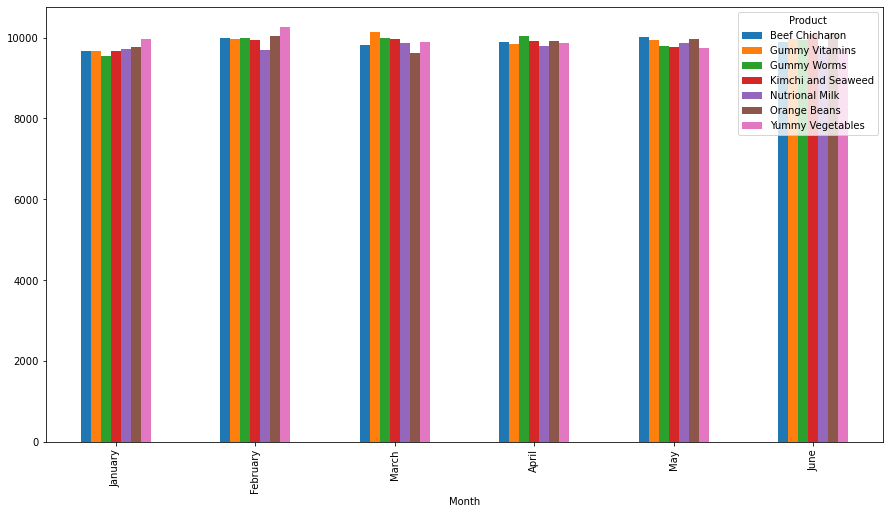

,January,February,March,April,May,June,Total
Product,,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902,59302
Gummy Vitamins,9681,9980,10145,9842,9948,9980,59576
Gummy Worms,9559,9996,9986,10043,9801,9934,59319
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104,59390
Nutrional Milk,9727,9691,9876,9786,9881,9767,58728
Orange Beans,9774,10037,9611,9914,9964,10106,59406
Yummy Vegetables,9959,10256,9896,9861,9735,9722,59429


In [1]:
import json
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np 

file = open('transaction-data-adhoc-analysis.json')
data = json.load(file)

df = pd.DataFrame(data)

datetomonth = {'/01/':'January',
         '/02/':'February',
         '/03/':'March',
         '/04/':'April',
         '/05/':'May',
         '/06/':'June'}

months = ['January', 'February', 'March','April','May','June']

for i in datetomonth: # to add the monthts into the df
    df.loc[df["transaction_date"].str.contains(i),"Month"] = datetomonth[i]

#function to add all the items per month 
def salepermonth(month):
    #get only the month in the parameter
    monthly = df[df["Month"]==month]
   
    #splits per item bought
    new_items = []
    for index, row in monthly.iterrows():
        #gets the row of the transaction items
        x = (row["transaction_items"].split(";"))
        #splits brand name, item and quantity
        for i in range(0,len(x)):
            new_items.append(x[i].split(','))
    #puts the separated brand, name, item and quantity in a new data frame
    item_df = pd.DataFrame(new_items,columns=['Brand','Product','Quantity'])
    
    #removes the (x) in the quantity column
    item_df['Quantity'] = item_df['Quantity'].str.replace('[^0-9]','', regex=True)
    #turns the column into an integer to be able to be added
    item_df['Quantity'] = item_df['Quantity'].astype(int)
    #groups the item by Product, while adding everything
    totalsum = item_df.groupby('Product').sum().squeeze()
    return totalsum

#returns the table for how many of each item is sold each month
soldpermonth = pd.DataFrame({i:salepermonth(i) for i in list(datetomonth.values())})

#turns the soldpermonth data frame into a bar graph
soldpermonth.transpose().reset_index(level=0).rename(columns={'index': 'Month'}).plot(x="Month", y=["Beef Chicharon","Gummy Vitamins","Gummy Worms", "Kimchi and Seaweed", "Nutrional Milk", "Orange Beans", "Yummy Vegetables"], kind="bar",figsize=(15,8))
#shows the bar graph
plt.show()

#get total number of each items sold at the end of the period
soldpermonth["Total"] = soldpermonth.sum(axis=1)
display(soldpermonth)


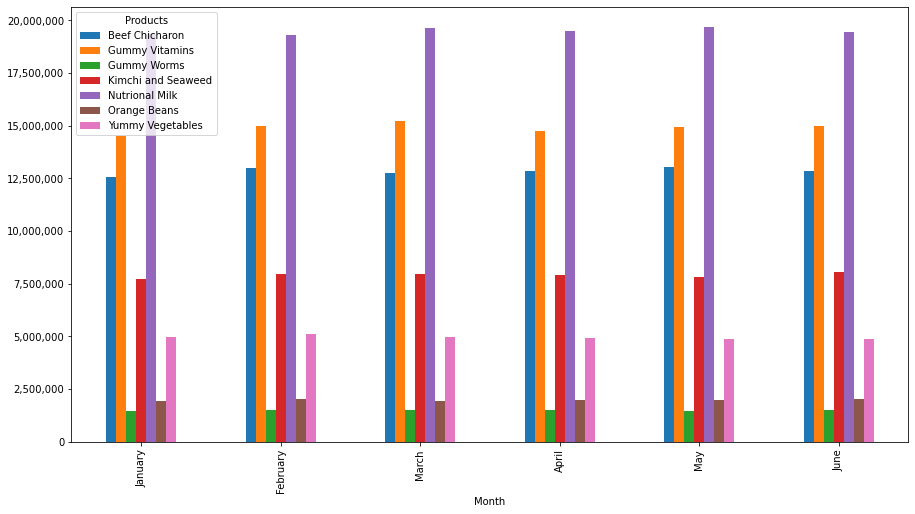

,Cost per Item,January,February,March,April,May,June
Products,,,,,,,
Yummy Vegetables,500.0,4979500.0,5128000.0,4948000.0,4930500.0,4867500.0,4861000.0
Gummy Worms,150.0,1433850.0,1499400.0,1497900.0,1506450.0,1470150.0,1490100.0
Beef Chicharon,1299.0,12554835.0,12991299.0,12750984.0,12847110.0,13026372.0,12862698.0
Kimchi and Seaweed,799.0,7731124.0,7949251.0,7963633.0,7926879.0,7808627.0,8073096.0
Orange Beans,199.0,1945026.0,1997363.0,1912589.0,1972886.0,1982836.0,2011094.0
Gummy Vitamins,1500.0,14521500.0,14970000.0,15217500.0,14763000.0,14922000.0,14970000.0
Nutrional Milk,1990.0,19356730.0,19285090.0,19653240.0,19474140.0,19663190.0,19436330.0
Total,,62522565.0,63820403.0,63943846.0,63420965.0,63740675.0,63704318.0


In [3]:
#getting the price chart, first check the transaction items column and selected the rows that did not contain ';' and the ones that had x1 and then dropped the duplicates, then changed the indexes to 0 to 6, then just chose the transaction items and transaction value columns.
pricechart = df[["transaction_items","transaction_value"]].drop_duplicates(subset=['transaction_items']).loc[(df['transaction_items'].str.contains(";") == False) & (df['transaction_items'].str.contains("x1"))].reset_index()

#to get only the item name from the price chart and make that as the indexes
def itemname(name):
    #gets the product name since the first .index gets first instance of the ',' and adds one, then cuts it from that point to the next instance of the ','
    itemname = name[name.index(",")+1:name.index(",",name.index(",")+1)]
    return itemname

#applies the new index names and puts it in the price_chart in a new column Products
pricechart['Products'] = pricechart['transaction_items'].apply(itemname)
transaction_value = pricechart.set_index('Products')['transaction_value'] #Sets the index as the products name

total_sales=pd.DataFrame({'Cost per Item':transaction_value}) #makes a data frame where the value is the transaction_value

#multiplies the cost per item with the sold per month in the table above, then adds it as a new column in the dataframe, with the column names as the months 
for i in list(soldpermonth.keys()):
    total_sales[i]=total_sales['Cost per Item']*soldpermonth[i]
    
#renames the columns and drops the extra total one
total_sales = total_sales[['Cost per Item','January','February','March','April','May','June']]

#creates the bar graph using the data frame
total_sales.transpose().drop('Cost per Item').reset_index(level=0).rename(columns={'index': 'Month'}).plot(x="Month", y=["Beef Chicharon","Gummy Vitamins","Gummy Worms", "Kimchi and Seaweed", "Nutrional Milk", "Orange Beans", "Yummy Vegetables"], kind="bar",figsize=(15,8)).get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))    
plt.show()

#creates the table with the total row with it
col_list = list(total_sales)
col_list.remove('Cost per Item')
total_sales.loc[len(total_sales.index)] = total_sales[col_list].sum()
display(total_sales.rename(index={7: 'Total'}).fillna(''))

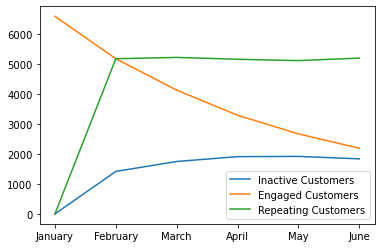

,January,February,March,April,May,June
Inactive Customers,0,1416,1747,1909,1917,1835
Engaged Customers,6588,5172,4126,3289,2667,2190
Repeating Customers,0,5172,5216,5154,5110,5193


In [8]:
def inactive(month):
    #to get the index of the month 
    month_value = months.index(month)
    #to get the months previous months in a list to check later if a customer is there
    past_months = months[:month_value]
    #gets the list of people who transacted during that month, and then drops the duplicates 
    current = df[df["Month"]==month].drop_duplicates(subset=['name'])
    #gets the list of people who transacted during the previous months before that current month
    previous = df[df["Month"].isin(past_months)].drop_duplicates(subset=['name'])
    #subtracting the people who were in the previous months to the ones who transacted this month means we get the people who didn't transact and are inactive
    return len(set(previous['name']) - set(current['name']))

#creates the series for the inactive customers for the month
inactive_customers = pd.Series({i:inactive(i) for i in months})

def repeating(month):
    #to get the index of the month 
    month_value = months.index(month)
    if month_value == 0:
        #to check if the month is january then there is no previous month
        previous_month = None
    else:
        #to check the previous month 
        previous_month = months[month_value-1:month_value][0]
    #gets the list of people who transacted during that month, and then drops the duplicates 
    current = df[df["Month"]==month].drop_duplicates(subset=['name'])
    #gets the list of people who transacted during the previous month, and then drops the duplicates 
    previous = df[df["Month"]==previous_month].drop_duplicates(subset=['name'])
    #returns the value of the list of those who are in the current month, and the ones in the previous month to count the repeating customers
    return len(set(current['name']) & set(previous['name']))

#creates the series for the repeating customers for the month
repeating_customers = pd.Series({i:repeating(i) for i in months})

def engaged(month):
    #gets the names and sorted by the month which it is in and then puts in to a set
    def custpermonth(month):
        engagedcust = sorted(df[df["Month"]==month].drop_duplicates(subset=['name'])['name'])
        return engagedcust
    #to create a dictionary of all the people who purchased per month 
    currentdict = {i:custpermonth(i) for i in list(datetomonth.values())}
    #setting variables
    firstmonth = months[0]
    engagedcust = set(currentdict[firstmonth])
    j = 0
    while j <= months.index(month):
        current = months[j]
        listcurrent = set(currentdict[current])
        #checks where the customer purchased in the first month and the the current month we are checking
        engagedcust = engagedcust & listcurrent
        j = j+1
        if j > months.index(month):
            return len(engagedcust)

engaged_customers = pd.Series({i:engaged(i) for i in months})
#concatenates the three series together in one table 
customers = pd.concat([inactive_customers, engaged_customers, repeating_customers], axis=1, keys=['Inactive Customers', 'Engaged Customers', 'Repeating Customers'])
#creates the line graph
customers.plot.line()
plt.show()
#shows the table for the customers
display(customers.transpose())